In [160]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

In [161]:
df = pd.read_csv('data/Expanded_data_with_more_features.csv')
df = df.drop(columns=['Unnamed: 0'])
df

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74
1,female,group C,some college,standard,NaN,married,sometimes,yes,0.0,NaN,5 - 10,69,90,88
2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91
3,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,NaN,5 - 10,45,56,42
4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,76,78,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30636,female,group D,high school,standard,none,single,sometimes,no,2.0,school_bus,5 - 10,59,61,65
30637,male,group E,high school,standard,none,single,regularly,no,1.0,private,5 - 10,58,53,51
30638,female,NaN,high school,free/reduced,completed,married,sometimes,no,1.0,private,5 - 10,61,70,67
30639,female,group D,associate's degree,standard,completed,married,regularly,no,3.0,school_bus,5 - 10,82,90,93


In [162]:
# Check if cuda is available
device = torch.device('cpu')

In [163]:
# Checking for NaN's
print(df.isnull().any())

Gender                 False
EthnicGroup             True
ParentEduc              True
LunchType              False
TestPrep                True
ParentMaritalStatus     True
PracticeSport           True
IsFirstChild            True
NrSiblings              True
TransportMeans          True
WklyStudyHours          True
MathScore              False
ReadingScore           False
WritingScore           False
dtype: bool


In [164]:
# Setting categorical features as numbers and removing NaN's by calculating mean value 
for column in df.columns:
    df[column] = df[column].astype('category').cat.codes
    df[column] = df[column].fillna(df[column].mean())
print(df.head())

   Gender  EthnicGroup  ParentEduc  LunchType  TestPrep  ParentMaritalStatus  \
0       0           -1           1          1         1                    1   
1       0            2           4          1        -1                    1   
2       0            1           3          1         1                    2   
3       1            0           0          0         1                    1   
4       1            2           4          1         1                    1   

   PracticeSport  IsFirstChild  NrSiblings  TransportMeans  WklyStudyHours  \
0              1             1           3               1               1   
1              2             1           0              -1               0   
2              2             1           4               1               1   
3              0             0           1              -1               0   
4              2             1           0               1               0   

   MathScore  ReadingScore  WritingScore  
0      

In [165]:
df.isnull().any()

Gender                 False
EthnicGroup            False
ParentEduc             False
LunchType              False
TestPrep               False
ParentMaritalStatus    False
PracticeSport          False
IsFirstChild           False
NrSiblings             False
TransportMeans         False
WklyStudyHours         False
MathScore              False
ReadingScore           False
WritingScore           False
dtype: bool

Text(0.5, 1.0, 'Korelacja między zmiennymi')

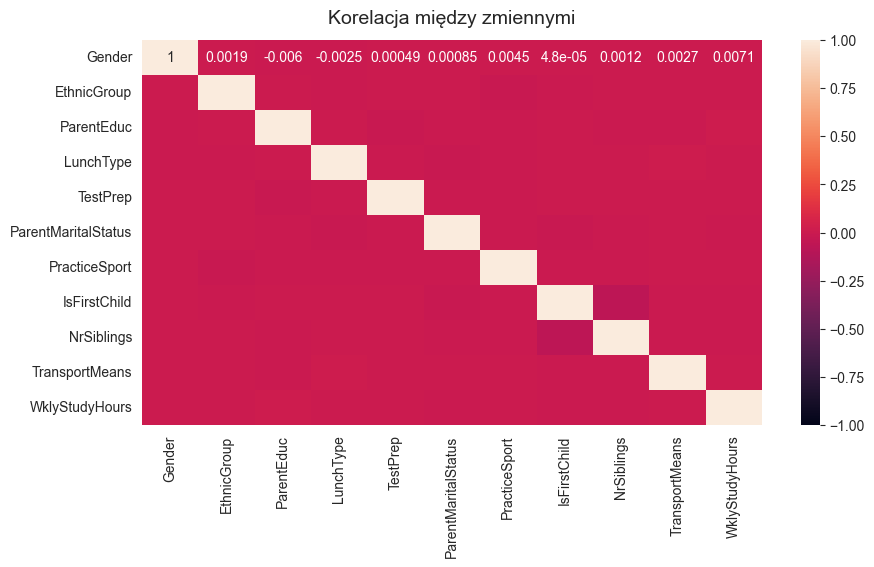

In [166]:
correlation_matrix = df.drop(['WritingScore', 'MathScore', 'ReadingScore'], axis=1).corr()
plt.figure(figsize=(10, 5))
heatmap = sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Korelacja między zmiennymi', fontdict={'fontsize': 14}, pad=12)

In [167]:
num_rows = len(df)
num_rows

30641

In [168]:
input_columns = list(df.drop(['WritingScore', 'MathScore', 'ReadingScore'], axis=1).columns)
input_columns

['Gender',
 'EthnicGroup',
 'ParentEduc',
 'LunchType',
 'TestPrep',
 'ParentMaritalStatus',
 'PracticeSport',
 'IsFirstChild',
 'NrSiblings',
 'TransportMeans',
 'WklyStudyHours']

In [169]:
output_columns = df.columns[-1]
output_columns

'WritingScore'

In [170]:
def dataframe_to_arrays(dataframe: pd.DataFrame) -> list[np.ndarray]:
    # Make a copy of original df
    df1 = dataframe.copy(deep=True)
    # Extract input & outputs as numpy arrays
    input_array = df1.drop(['WritingScore', 'MathScore', 'ReadingScore'], axis=1).values
    target_array = df1[['WritingScore']].values
    return [input_array, target_array]

In [171]:
inputs_array = dataframe_to_arrays(df)[0]
targets_array = dataframe_to_arrays(df)[1]
print(inputs_array.shape, targets_array.shape)
inputs_array, targets_array

(30641, 11) (30641, 1)


(array([[ 0, -1,  1, ...,  3,  1,  1],
        [ 0,  2,  4, ...,  0, -1,  0],
        [ 0,  1,  3, ...,  4,  1,  1],
        ...,
        [ 0, -1,  2, ...,  1,  0,  0],
        [ 0,  3,  0, ...,  3,  1,  0],
        [ 1,  1,  4, ...,  1,  1,  0]], dtype=int8),
 array([[66],
        [80],
        [83],
        ...,
        [59],
        [85],
        [50]], dtype=int8))

In [172]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(pd.read_csv('data/Expanded_data_with_more_features.csv'))
joblib.dump(vectorizer, './data/vectorizer.pkl')

['./data/vectorizer.pkl']

In [173]:
inputs = torch.from_numpy(inputs_array).to(torch.float32)
targets = torch.from_numpy(targets_array).to(torch.float32)

In [174]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

In [175]:
print((inputs, targets))

(tensor([[ 0., -1.,  1.,  ...,  3.,  1.,  1.],
        [ 0.,  2.,  4.,  ...,  0., -1.,  0.],
        [ 0.,  1.,  3.,  ...,  4.,  1.,  1.],
        ...,
        [ 0., -1.,  2.,  ...,  1.,  0.,  0.],
        [ 0.,  3.,  0.,  ...,  3.,  1.,  0.],
        [ 1.,  1.,  4.,  ...,  1.,  1.,  0.]]), tensor([[66.],
        [80.],
        [83.],
        ...,
        [59.],
        [85.],
        [50.]]))


In [176]:
dataset = TensorDataset(inputs, targets)

In [177]:
val_percent = 0.20
val_size = int(num_rows * val_percent)
print(val_size)
train_size = num_rows - val_size
print(train_size)

# use the random_split function to split dataset into 2 parts of the desired length
train_ds, val_ds = random_split(dataset, [train_size, val_size])

6128
24513


In [178]:
print(len(train_ds), len(val_ds))

24513 6128


In [179]:
batch_size = 32

In [180]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [181]:
# for xb, yb in train_loader:
#     print(f'inputs: {xb}')
#     print(f'targets: {yb}')

#  Create a Linear Regression Model

In [182]:
input_size = len(input_columns)
print(input_size)
hidden_size = int(input_size / 2)
print(hidden_size)
hidden_size2 = int(hidden_size / 2)
print(hidden_size2)
output_size = 1
print(output_size)

11
5
2
1


In [183]:
class WritingScoreModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(WritingScoreModel, self).__init__()
        self.linear1 = nn.Linear(input_size, 8)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(8, output_size)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        return x

    def training_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs.to(device))
        # Calculate loss
        loss = F.l1_loss(out.to(device), targets.to(device))
        return loss

    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs.to(device))
        # Calculate loss
        loss = F.l1_loss(out.to(device), targets.to(device))
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        # Combine losses
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result, num_epochs):
        # Print result after 20th epoch
        if (epoch + 1) % 500 == 0 or epoch == num_epochs - 1:
            print(f'Epoch {epoch + 1}, val_loss {result["val_loss"]}')

In [184]:
model = WritingScoreModel(input_size, output_size).to(device)

  0%|          | 0/25 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.81E-05


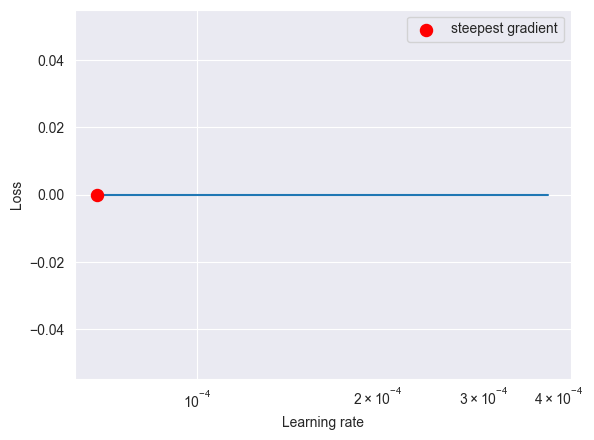

In [185]:
from torch_lr_finder import LRFinder
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)
lr_finder = LRFinder(model, optimizer, criterion, device) 
lr_finder.range_test(train_loader, end_lr = 0.001, num_iter = 25)
lr_finder.plot()
lr_finder.reset()

In [186]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.2034,  0.0938,  0.1783, -0.1287, -0.2557, -0.2461,  0.2075,  0.1368,
          -0.2968,  0.2841,  0.1251],
         [ 0.2202, -0.1636,  0.1288,  0.1857, -0.0871, -0.1990, -0.0524, -0.0770,
           0.0273, -0.2969,  0.2150],
         [ 0.1553,  0.1565, -0.1640,  0.1552, -0.2547,  0.1498,  0.1422, -0.2867,
          -0.2467, -0.0846,  0.2117],
         [-0.1128,  0.0684, -0.2753, -0.0029,  0.2647,  0.1872,  0.0562, -0.1091,
          -0.1001,  0.1886, -0.2852],
         [ 0.1615, -0.2968, -0.2434,  0.2783,  0.0013, -0.2453, -0.0794, -0.2084,
          -0.0315, -0.1925,  0.0497],
         [-0.0807,  0.0717, -0.1305, -0.1696, -0.0453, -0.0458, -0.1235,  0.0562,
          -0.1487, -0.1967, -0.2264],
         [-0.1208,  0.2746,  0.1375, -0.1983,  0.0108,  0.1500,  0.2844, -0.1494,
          -0.1633, -0.3005,  0.0873],
         [ 0.0290, -0.0357, -0.2548, -0.3000,  0.1806,  0.2416, -0.0227,  0.2819,
          -0.2266,  0.2047,  0.1637]], requires_grad=Tr

In [187]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=optim.SGD) -> list:
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [188]:
result = evaluate(model, val_loader)
print(result)

{'val_loss': 60.23525619506836}


In [189]:
# model = WritingScoreModel()

In [190]:
epochs = 2000
lr = 6.81E-05
history = fit(epochs, lr, model, train_loader, val_loader)

Epoch 500, val_loss 11.141196250915527
Epoch 1000, val_loss 11.139250755310059
Epoch 1500, val_loss 11.136395454406738
Epoch 2000, val_loss 11.11983871459961


In [191]:
val_loss = history[-1]
val_loss

{'val_loss': 11.11983871459961}

In [192]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs.to(device))
    prediction = predictions[0].detach()
    print(f'Input: {input}')
    print(f'Target: {target}')
    print(f'Prediction: {prediction}')

In [193]:
input, target = val_ds[5]
print(type(val_ds))
predict_single(input, target, model)

<class 'torch.utils.data.dataset.Subset'>
Input: tensor([0., 3., 4., 0., 0., 0., 1., 1., 1., 0., 2.])
Target: tensor([85.])
Prediction: tensor([63.0443])


In [194]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([ 1., -1.,  4.,  0.,  1.,  2.,  2.,  1.,  1.,  1., -1.])
Target: tensor([32.])
Prediction: tensor([41.9930])


In [195]:
input,target = val_ds[13]
predict_single(input, target, model)

Input: tensor([ 1.,  3.,  2.,  1.,  1.,  1.,  2.,  1.,  2.,  0., -1.])
Target: tensor([64.])
Prediction: tensor([58.1582])


In [196]:
input,target = val_ds[54]
predict_single(input, target, model)

Input: tensor([ 1.,  0.,  1.,  1.,  1.,  2.,  0.,  1., -1.,  0.,  1.])
Target: tensor([71.])
Prediction: tensor([53.8878])


In [197]:
input,target = val_ds[87]
predict_single(input, target, model)

Input: tensor([0., 2., 2., 0., 1., 1., 1., 0., 1., 1., 0.])
Target: tensor([57.])
Prediction: tensor([56.7541])


In [198]:
torch.save(model, './data/writing_score_model.pt')

In [199]:
print(val_ds[87])
print(type(val_ds[87]))

(tensor([0., 2., 2., 0., 1., 1., 1., 0., 1., 1., 0.]), tensor([57.]))
<class 'tuple'>


In [200]:
model_input = torch.tensor([1., 2., 5., 0., 1., 2., 0., 1., 1., 1., 0.], dtype=torch.float32)

In [201]:
output = model(model_input)
float(output[0])

45.27764892578125